## Data preprocessing and exploration with embeddings and kmeans clustering

In this we will be analyze the textual information(analysis and attribute_names) using contexual embeddings from the bert tokenizer and model and try to cluster(using kmeans clustering) these to identify different groups.

1. We will get a 1*768 vector representation of the input texts from bert model

2. We use this as inputs to the kmeans clustering algorithm.

Example:
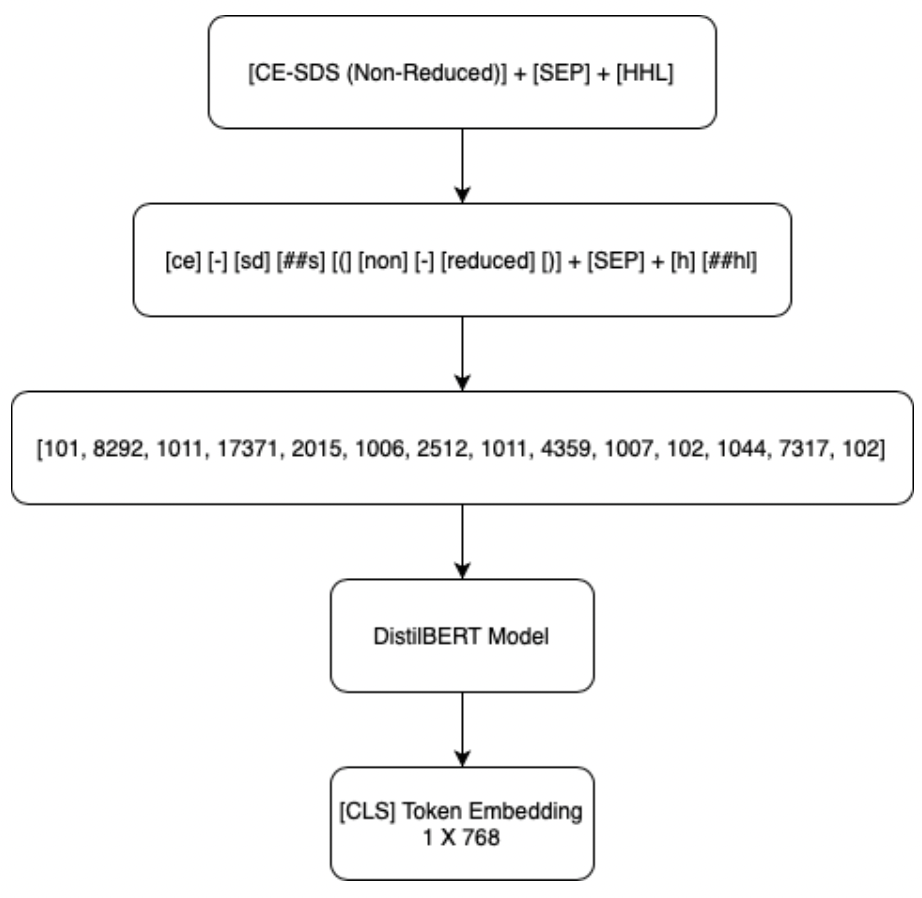

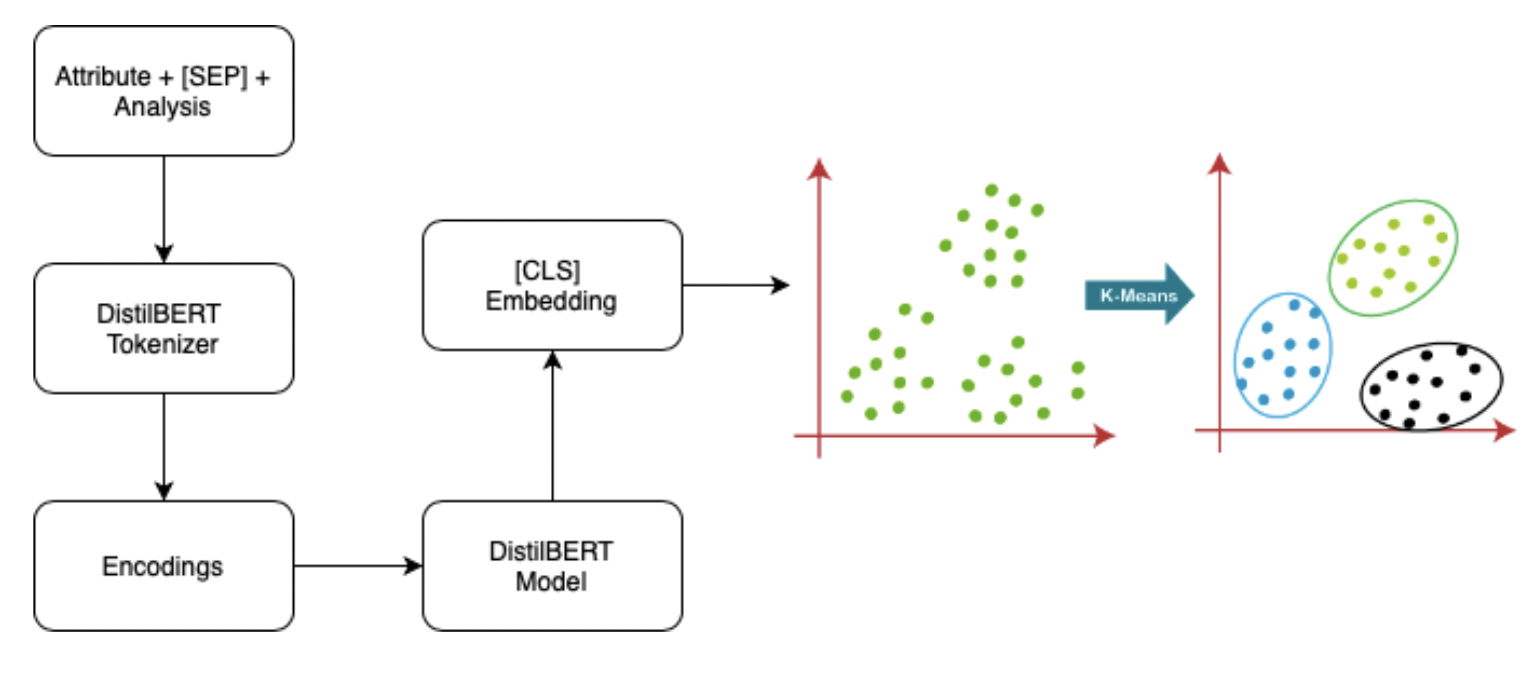

In [15]:
import pandas as pd

attributes = pd.read_excel("bms_data.xlsx")
attributes.head()

,analysis,Attribute_name
0,D_250475,IL2 INHIBITION ASSAY
1,D_95007196,PH
2,D_M00003744,ABATACEPT MAJOR BAND (REDUCED)
3,Y_SM_95011468_R,BIOASSAY
4,250684_CE_SDS_REDUC,SUM HEAVY AND LIGHT CHAIN


In [16]:
print("Before dropping NAs:", attributes.shape)
attributes.dropna(inplace=True, ignore_index=True)
print("After dropping NAs:", attributes.shape)

Before dropping NAs: (7730, 2)
After dropping NAs: (7726, 2)


In [17]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

In [18]:
attributes["analysis"]=attributes["analysis"].fillna("").astype(str)
attributes["Attribute_name"]=attributes["Attribute_name"].fillna("").astype(str)

In [19]:
attributes["Analysis_tokens"] = attributes['analysis'].apply(lambda x: " ".join(tokenizer.tokenize(x)))
attributes["Attribute_tokens"] = attributes["Attribute_name"].apply(lambda x: " ".join(tokenizer.tokenize(x)))

In [20]:
attributes = attributes[["analysis", "Analysis_tokens", "Attribute_name", "Attribute_tokens"]]
attributes.head()

,analysis,Analysis_tokens,Attribute_name,Attribute_tokens
0,D_250475,d _ 250 ##47 ##5,IL2 INHIBITION ASSAY,il ##2 inhibition ass ##ay
1,D_95007196,d _ 950 ##0 ##7 ##19 ##6,PH,ph
2,D_M00003744,d _ m ##00 ##00 ##37 ##44,ABATACEPT MAJOR BAND (REDUCED),aba ##ta ##ce ##pt major band ( reduced )
3,Y_SM_95011468_R,y _ sm _ 950 ##11 ##46 ##8 _ r,BIOASSAY,bio ##ass ##ay
4,250684_CE_SDS_REDUC,250 ##6 ##8 ##4 _ ce _ sd ##s _ red ##uc,SUM HEAVY AND LIGHT CHAIN,sum heavy and light chain


In [21]:
encodings = tokenizer(attributes["analysis"].tolist(), attributes["Attribute_name"].tolist(), padding=True, truncation=True, return_tensors='pt')

In [22]:
encodings.keys()

dict_keys(['input_ids', 'attention_mask'])

In [23]:
encodings["input_ids"][0]

tensor([  101,  1040,  1035,  5539, 22610,  2629,   102,  6335,  2475, 23586,
         4632,  4710,   102,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0])

In [25]:
import torch
from transformers import AutoModel

# Load the model
model = AutoModel.from_pretrained('distilbert-base-uncased')
model.to('cuda')  # Move model to GPU
model.eval()

# Ensure encodings are on the same device (GPU)
encodings = {key: val.to('cuda') for key, val in encodings.items()}  # Move all tensors in encodings to GPU

with torch.no_grad():  # Disable gradient calculation for inference
    outputs = model(**encodings)

token_embeddings = outputs.last_hidden_state


In [26]:
token_embeddings.shape

torch.Size([7726, 37, 768])

torch.Size([7726, 37, 768]) means:

7726 sequences (or sentences, documents) are being processed in parallel (batch size).

Each sequence has 37 tokens (sequence length).

Each token is represented as a 768-dimensional vector (embedding size).

In [30]:
token_embeddings[:,0,:]

tensor([[-0.3719, -0.0638, -0.0487,  ..., -0.1843,  0.1036,  0.3934],
        [-0.2787,  0.0013,  0.0750,  ..., -0.1261,  0.0954,  0.4797],
        [-0.3711, -0.1454,  0.0352,  ...,  0.0098,  0.0940,  0.4060],
        ...,
        [-0.3695, -0.3323,  0.0678,  ..., -0.2147,  0.1359,  0.6410],
        [-0.4755, -0.1995,  0.0959,  ..., -0.1248,  0.2575,  0.4596],
        [-0.3286, -0.0230, -0.1473,  ..., -0.0829,  0.2328,  0.4458]],
       device='cuda:0')

In [31]:
# Using CLS token
cls_embeddings = token_embeddings[:, 0, :]

In [32]:
# Mean pooling (average over the token embeddings excluding padding)
attention_mask = encodings['attention_mask']  # To exclude padding tokens from the mean
mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()

sum_embeddings = torch.sum(token_embeddings * mask_expanded, 1)
sum_mask = torch.clamp(mask_expanded.sum(1), min=1e-9)
mean_embeddings = sum_embeddings / sum_mask

In [34]:
from sklearn.cluster import KMeans

embeddings = mean_embeddings.cpu().numpy()

# Perform K-Means clustering
kmeans = KMeans(n_clusters=32, random_state=42)
kmeans.fit(embeddings)

# Get the cluster labels for each input
cluster_labels = kmeans.predict(embeddings)
print("Cluster labels:", cluster_labels)


Cluster labels: [26 10  2 ...  9  1 13]


In [35]:
attributes["Cluster"] = cluster_labels
attributes.head()

,analysis,Analysis_tokens,Attribute_name,Attribute_tokens,Cluster
0,D_250475,d _ 250 ##47 ##5,IL2 INHIBITION ASSAY,il ##2 inhibition ass ##ay,26
1,D_95007196,d _ 950 ##0 ##7 ##19 ##6,PH,ph,10
2,D_M00003744,d _ m ##00 ##00 ##37 ##44,ABATACEPT MAJOR BAND (REDUCED),aba ##ta ##ce ##pt major band ( reduced ),2
3,Y_SM_95011468_R,y _ sm _ 950 ##11 ##46 ##8 _ r,BIOASSAY,bio ##ass ##ay,2
4,250684_CE_SDS_REDUC,250 ##6 ##8 ##4 _ ce _ sd ##s _ red ##uc,SUM HEAVY AND LIGHT CHAIN,sum heavy and light chain,2


In [ ]:
attributes.sort_values(by=['Cluster'], inplace=True, ignore_index=True)
# attributes.to_csv("cluster_mean_embed.csv")
attributes.to_csv("cluster_cls_token.csv")

In [36]:
# using cls embeding instead of mean_embeddings
embeddings = cls_embeddings.cpu().numpy()

# Perform K-Means clustering
kmeans = KMeans(n_clusters=32, random_state=42)
kmeans.fit(embeddings)

# Get the cluster labels for each input
cluster_labels = kmeans.predict(embeddings)
print("Cluster labels:", cluster_labels)

Cluster labels: [14 30  2 ...  3  1 19]


In [37]:
attributes["cls_Cluster"] = cluster_labels
attributes.head()

,analysis,Analysis_tokens,Attribute_name,Attribute_tokens,Cluster,cls_Cluster
0,D_250475,d _ 250 ##47 ##5,IL2 INHIBITION ASSAY,il ##2 inhibition ass ##ay,26,14
1,D_95007196,d _ 950 ##0 ##7 ##19 ##6,PH,ph,10,30
2,D_M00003744,d _ m ##00 ##00 ##37 ##44,ABATACEPT MAJOR BAND (REDUCED),aba ##ta ##ce ##pt major band ( reduced ),2,2
3,Y_SM_95011468_R,y _ sm _ 950 ##11 ##46 ##8 _ r,BIOASSAY,bio ##ass ##ay,2,6
4,250684_CE_SDS_REDUC,250 ##6 ##8 ##4 _ ce _ sd ##s _ red ##uc,SUM HEAVY AND LIGHT CHAIN,sum heavy and light chain,2,6


In [ ]:
attributes.sort_values(by=['Cluster'], inplace=True, ignore_index=True)
# attributes.to_csv("cluster_mean_embed.csv")
attributes.to_csv("cluster_cls_token.csv")